## CNN LSTM Test
This notebook measures the capabilities of CNN-LSTM Model created on SOCAT and a separate member/ dataset.

### Different Member Test


In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_images_nfp

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-02-28 12:28:40.364518: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-02-28 12:28:40.364968: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images_nfp(dir_name)

test_data,test_pco2 = preprocess_images_nfp(val_dir_name,"035")

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

In [4]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

# gives you gradient exploding problem
y=np.expand_dims(test_pco2[X_index][1:],axis=4)
X=test_data[X_index][:-1]
print(X.shape, y.shape)

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)


In [5]:
best_model = tf.keras.models.load_model('../../models/base_CNN_LSTM.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_frames=best_model.predict(X,verbose=1)

2022-02-28 12:29:22.603936: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-28 12:29:22.628326: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-02-28 12:29:22.639297: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-28 12:29:22.639472: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (g126): /proc/driver/nvidia/version does not exist
2022-02-28 12:29:22.683786: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

14/14 [==============================] - 199s 14s/step


In [6]:
predicted_frames[y==0]=0.0

In [7]:
def inverse_scale_image_nfp(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)
    y_pred = arr*(old_max-old_min)/255+old_min
    
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [9]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2_tmp = read_xarray(dir_name)

y_true,y_pred=inverse_scale_image_nfp(predicted_frames,pco2_tmp.pCO2.data)  

In [10]:
np.sqrt(np.sum((y_true[:,:1]-y_pred[:,:1])**2)/np.sum(y_pred!=0.0))

9.957570503219705

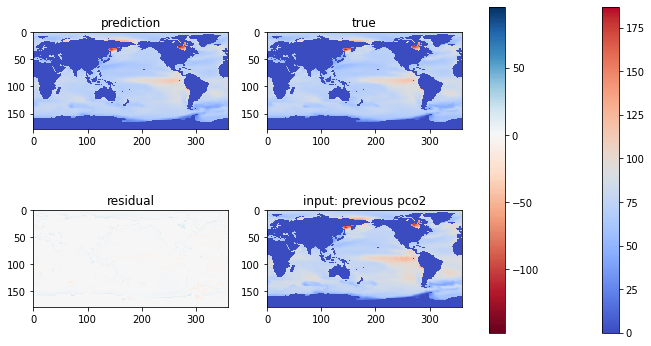

In [18]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 2,figsize=(12, 6))

d = predicted_frames - y
norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)


img=axis[0][0].imshow(np.flipud(predicted_frames[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_frames[0][1]-y[0][1]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(X[0][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("input: previous pco2")

plt.show()

### SOCAT

In [20]:
data_socat,pco2_socat = preprocess_images_nfp(dir_name,socat=True)
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

y=np.expand_dims(pco2_socat[X_index][1:],axis=4)
X=data_socat[X_index][:-1]
print(X.shape, y.shape)

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)


In [21]:
predicted_frames=best_model.predict(X,verbose=1)

14/14 [==============================] - 10s 755ms/step


In [22]:
predicted_frames[y==0]=0.0

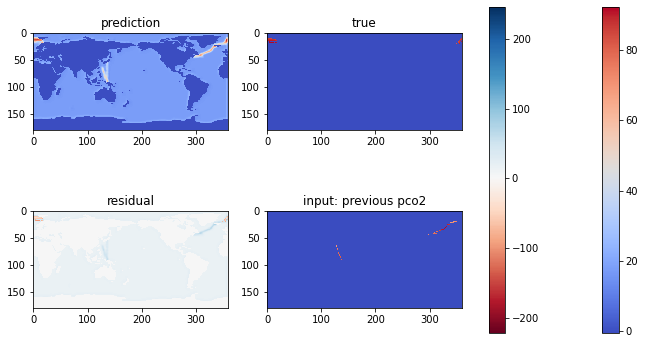

In [23]:
figure, axis = plt.subplots(2, 2,figsize=(12, 6))

d = predicted_frames - y
norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)


img=axis[0][0].imshow(np.flipud(predicted_frames[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_frames[0][1]-y[0][1]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(X[0][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("input: previous pco2")

plt.show()